## Analyse Sqrt run

In [45]:
%matplotlib inline
from __future__ import division
import likelihoodfree.io as io
import likelihoodfree.viz as viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

from numpy import unravel_index

## Loading results

In [32]:
# loading filename and paths
prefix = 'testd1iwsvi'
basepath = '../results/sqrt/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'

# create folder for plots
save_plot_flag = 1
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)

# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs

# posterior
l_posteriors = list(posteriors.items())
posterior = l_posteriors[len(l_posteriors)-1][1]

###############################################################################
# ground-truth parameters
true_params = l_sims[0][1].true_params

###############################################################################
# prior
true_prior = l_sims[len(sims)-1][1].prior

###############################################################################
# true posterior
true_posterior = l_sims[len(sims)-1][1].posterior

###############################################################################
# simulator
forward_model = l_sims[len(sims)-1][1].forward_model

## Approximation to true posterior

In [88]:
def gauss1D(x,mean,var):
    return ((2 * np.pi) ** (-0.5)) * (1 / np.sqrt(var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)

def kernel(x,y,eps):
    return gauss1D(x,y,eps ** 2)

def qw(theta,mu_grid,eps_grid):
    return gauss1D(theta,mu_grid,eps_grid)

def log_qw(theta,mu_grid,eps_grid):
    return np.log(qw(theta,mu_grid,eps_grid))

# approximate Lw using MC integration with n steps
def Lw_approx(prior_mean,eta,true_mean,sigma,x0,eps,mu_grid,eps_grid,n = 1000):
    thetas = np.random.normal(prior_mean, eta, size=n)
    xes = np.random.normal(np.sqrt(thetas), sigma)

    ret = 0.
    for theta, x in zip(thetas,xes):
        ret -= log_qw(theta,mu_grid,eps_grid) * kernel(x,x0,eps)

    return ret / len(thetas)

def max_Lw(prior_mean,eta,true_mean,sigma,x0,eps,mu_grid,eps_grid):
    LW = np.zeros((len(mu_grid),len(eps_grid)))
    for i in range(len(mu_grid)):
        for j in range(len(eps_grid)):
            LW[i,j] = Lw_approx(prior_mean,eta,true_mean,sigma,x0,eps,mu_grid[i],eps_grid[j])
    idx = unravel_index(LW.argmin(), LW.shape)
    return mu_grid[idx[0]],mu_grid[idx[1]]

    
prior_cov=1.0
prior_mean=5.0
true_mean=3.0
noise_cov=0.1
eps = 0.2

n_brut = 100
mu_grid = np.linspace(0.01, 10, n_brut)
eps_grid = np.linspace(0.01, 5, n_brut)

mu_brut_post, eps_brut_post = max_Lw(prior_mean,prior_cov,true_mean,noise_cov,obs_stats,eps, mu_grid, eps_grid)

In [89]:
eps_brut_post

9.1927272727272715

In [87]:
mu_brut_post

3.3399999999999999

## Prior, true and estimated posteriors, samples from prior

In [34]:
# sampling from estimated posterior and running forward model
n_samp = 500
theta_samp = np.zeros(n_samp)
x_samp = np.zeros(n_samp)
for i in range(n_samp):
    theta_samp[i] = posterior.gen(1).reshape(-1)
    x_samp[i] = forward_model(np.array([theta_samp[i]]))
       
# contour values for prior, true posterior and estimated posterior
lims = np.array([[0],[10]])
n_grid = 200
yy = np.linspace(lims[0], lims[1], n_grid)
xx = 0.*yy
pp_prior = 0.*yy
x0_grid = np.sqrt(yy)
pp_true = np.tile(0.*yy,(len(x0_grid),1))
pp_estimated = np.tile(0.*yy,(len(sims),1))
for i in range(n_grid):
    xx[i] = forward_model(np.array([yy[i]]))
    pp_prior[i] = true_prior.eval(np.array([[yy[i]]]), log=False)
    for j in range(len(sims)):
        posterior1 = l_posteriors[j][1]
        pp_estimated[j,i] = posterior1.eval(np.array([[yy[i]]]), log=False)
        
#     for j in range(n_grid):
# #         pp_true[j,i] = true_posterior(x_obs1=x0_grid[j]).eval(np.array([[yy[i]]]), log=False)
    pp_true[i,:] = gauss1D(yy,mu_brut_post,eps_brut_post)

## Plotting

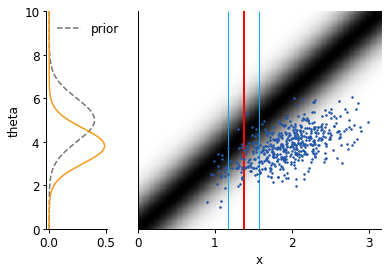

In [35]:
fig = plt.figure()
ax = plt.subplot()

col_0 = (35/255,86/255,167/255)
col_1 = (0, 174/255,239/255)
col_2 = (244/255, 152/255, 25/255)

gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 4])

ax = plt.subplot(gs[0])
plt.plot(pp_prior,yy,'--',color='0.45', label='prior')

num_colors = len(sims)+1
cm1 = mpl.cm.Oranges
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]
# for i in range(len(sims)):
#     plt.plot(pp_estimated[i,:],yy,color=col1[i])
plt.plot(pp_estimated[len(sims)-1,:],yy,color=col_2)
ax.set_ylim(lims)
plt.ylabel('theta')
plt.legend()


ax = plt.subplot(gs[1])
lims1 = np.array([[np.sqrt(lims[0,0]),np.sqrt(lims[1,0])],[lims[0,0],lims[1,0]]])
plt.plot(x_samp, theta_samp,'.',color=col_0)
ax.imshow(-pp_true,origin='lower',cmap='gray',
          extent=[lims1[0, 0],lims1[0, 1],lims1[1 ,0],lims1[1 ,1]],
          aspect='auto', interpolation='none')

# ax.plot(obs_stats, true_params, 'r.', ms=15)
ax.vlines(obs_stats, 0, ax.get_ylim()[1], lw=2, color='r')

ax.vlines(obs_stats-eps, 0, ax.get_ylim()[1], lw=1, color=col_1)
ax.vlines(obs_stats+eps, 0, ax.get_ylim()[1], lw=1, color=col_1)

ax.set_xlim(np.sqrt(lims))
ax.set_ylim(lims)
ax.set_yticks([])
plt.xlabel('x')

plt.savefig('fig1b.pdf')
plt.show()

In [ ]:
lims1

In [ ]:
posterior_mean = lambda x: true_posterior(x_obs1=np.array([[x**2]])).m

In [ ]:
plt.plot([posterior_mean(x) for x in np.linspace(0,3,100)])

In [ ]:
posterior_cov = np.linalg.inv(np.linalg.inv(1*np.eye(1))+np.linalg.inv(0.1*np.eye(1)))
posterior_mu = np.dot(posterior_cov, (np.dot(np.linalg.inv(0.1*np.eye(1)), (obs_stats*np.eye(1)).reshape(-1))+np.dot(np.linalg.inv(1*np.eye(1)), 5*np.eye(1))))

In [ ]:
posterior_mu

In [ ]:
xc=np.linspace(1,5,10)
plt.plot(xc,xc*xc)